In [ ]:
import pandas as pd
df_hz = pd.read_csv("LaDe_full/delivery/delivery_hz.csv")
df_cq = pd.read_csv("LaDe_full/delivery/delivery_cq.csv")
df_jl = pd.read_csv("LaDe_full/delivery/delivery_jl.csv")
df_sh = pd.read_csv("LaDe_full/delivery/delivery_sh.csv")
df_yt = pd.read_csv("LaDe_full/delivery/delivery_yt.csv")

,order_id,from_dipan_id,from_city_name,delivery_user_id,poi_lng,poi_lat,aoi_id,typecode,receipt_time,receipt_lng,receipt_lat,sign_time,sign_lng,sign_lat,ds
0,687227b4d0c733049b16ccd566db6e01,08331170e24742ba7a3938f5b34ff24d,上海市,18ff78d2069125937a847fb701a9db6c,1.056351e+07,-7.458321e+06,e0581ca18e7ca371a9869e041cb09075,4602b38053ece07a9ca5153f1df2e404,03-18 13:35:00,1.056160e+07,-7.457998e+06,03-18 14:51:00,NaN,NaN,318
1,55be8cdf1270526231c9ba3387f51b54,c5ac5ba99801aa6b85ba473d9260512b,重庆市,df0b594618d1ba6f619e4e7dd034447c,8.899874e+06,-7.684936e+06,9c0f96ff01a71477334ef563001abc72,203ac3454d75e02ebb0a3c6f51d735e4,03-18 08:32:00,8.900992e+06,-7.686103e+06,03-18 14:33:00,NaN,NaN,318
2,ee46cae9ba2c002451af3c6fbcb49410,2129bfb99a2f6c11000c0ecbf1a5f3f6,上海市,05cceaaa5db96756294dd6d573fd865d,1.058131e+07,-7.467397e+06,4de9bf7f155046e7d0fd400672ab9cf3,203ac3454d75e02ebb0a3c6f51d735e4,03-18 13:02:00,1.058124e+07,-7.467607e+06,03-18 15:34:00,NaN,NaN,318
3,38912be86c83138901b5e26398832be7,08331170e24742ba7a3938f5b34ff24d,上海市,f29e97ef8398477abb72b852b16c91c0,1.056273e+07,-7.456804e+06,fe48cde9b33e2308641d985f8a701c7e,203ac3454d75e02ebb0a3c6f51d735e4,03-18 12:11:00,1.056160e+07,-7.457997e+06,03-18 14:08:00,NaN,NaN,318
4,2b83e2ba16714fee357694964d0e7e41,4fe96250270c2e17a28016a5fba4bc4a,杭州市,1d00e6f2308aad233f0179aac63aa23d,1.044847e+07,-7.587086e+06,a7d4de5484ca867fe453976ba9fee424,4602b38053ece07a9ca5153f1df2e404,03-18 07:28:00,1.044791e+07,-7.586259e+06,03-20 12:40:00,NaN,NaN,318


In [17]:
df_raw = pd.concat(
    [df_hz, df_cq, df_jl, df_sh, df_yt],
    ignore_index=True
)

In [19]:
fact_cols = [
    "order_id",
    "accept_time",
    "delivery_time",
    "city",
    "aoi_id",
    "aoi_type",
    "courier_id",
    "ds"
]

df = df_raw[fact_cols].copy()

In [ ]:
YEAR = 2022

df["accept_time"] = pd.to_datetime(
    df["accept_time"].apply(lambda x: f"{YEAR}-{x}"),
    errors="coerce"
)

df["delivery_time"] = pd.to_datetime(
    df["delivery_time"].apply(lambda x: f"{YEAR}-{x}"),
    errors="coerce"
)

In [ ]:
df["delivery_duration_minutes"] = (
    (df["delivery_time"] - df["accept_time"])
    .dt.total_seconds()
    .div(60)
    .astype("Int64")
)

In [22]:
df_fact_delivery = df[
    [
        "order_id",
        "accept_time",
        "delivery_time",
        "delivery_duration_minutes",
        "city",
        "aoi_id",
        "aoi_type",
        "courier_id",
        "ds",
    ]
]

In [23]:
df_fact_delivery.head()
df_fact_delivery.dtypes
df_fact_delivery["delivery_duration_minutes"].describe()

count     4514661.0
mean      185.82572
std      780.114327
min       -421417.0
25%            56.0
50%           105.0
75%           193.0
max        166499.0
Name: delivery_duration_minutes, dtype: Float64

In [25]:
df_neg = df_fact_delivery[
    df_fact_delivery["delivery_duration_minutes"] < 0
]

df_neg.head(5)


,order_id,accept_time,delivery_time,delivery_duration_minutes,city,aoi_id,aoi_type,courier_id,ds
2301898,3739029,2022-10-31 10:57:00,2022-01-11 19:20:00,-421417,Chongqing,28470,14,2954,1031
2380010,3212380,2022-10-31 12:14:00,2022-01-13 14:16:00,-418918,Chongqing,55255,14,486,1031
2384159,3956975,2022-10-22 17:54:00,2022-01-19 12:56:00,-397738,Chongqing,57605,14,3893,1022


In [26]:
(
    df_neg["delivery_time"].dt.month <
    df_neg["accept_time"].dt.month
).value_counts()


True    3
Name: count, dtype: int64

In [28]:
df_big = df_fact_delivery[
    df_fact_delivery["delivery_duration_minutes"] > 10000
]
df_big.info()
df_big[[
    "accept_time",
    "delivery_time",
    "delivery_duration_minutes",
    "ds"
]].head(10)


<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 1384 to 4497226
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   order_id                   1820 non-null   int64         
 1   accept_time                1820 non-null   datetime64[ns]
 2   delivery_time              1820 non-null   datetime64[ns]
 3   delivery_duration_minutes  1820 non-null   Int64         
 4   city                       1820 non-null   object        
 5   aoi_id                     1820 non-null   int64         
 6   aoi_type                   1820 non-null   int64         
 7   courier_id                 1820 non-null   int64         
 8   ds                         1820 non-null   int64         
dtypes: Int64(1), datetime64[ns](2), int64(5), object(1)
memory usage: 144.0+ KB


,accept_time,delivery_time,delivery_duration_minutes,ds
1384,2022-09-29 17:58:00,2022-10-20 07:08:00,29590,929
13870,2022-09-27 16:48:00,2022-10-11 22:21:00,20493,927
20606,2022-10-23 09:36:00,2022-11-23 13:37:00,44881,1023
30635,2022-10-24 09:25:00,2022-11-08 22:04:00,22359,1024
43362,2022-08-27 11:58:00,2022-09-04 11:56:00,11518,827
52230,2022-10-13 11:22:00,2022-10-20 23:20:00,10798,1013
52242,2022-10-19 11:12:00,2022-11-17 19:36:00,42264,1019
52663,2022-09-27 16:07:00,2022-10-05 19:21:00,11714,927
53044,2022-05-30 08:43:00,2022-06-06 23:40:00,10977,530
53150,2022-07-11 08:47:00,2022-07-18 19:40:00,10733,711


In [29]:
df_fact_delivery["delivery_duration_minutes"].quantile(
    [0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]
)

0.500      105.0
0.750      193.0
0.900      328.0
0.950      483.0
0.990     1521.0
0.995     2250.0
0.999    6766.38
Name: delivery_duration_minutes, dtype: Float64

In [30]:
total = len(df_fact_delivery)

(df_fact_delivery["delivery_duration_minutes"] > 1440).sum() / total

np.float64(0.010762712859282236)

Text(0.5, 1.0, 'Delivery Duration Distribution (clipped)')

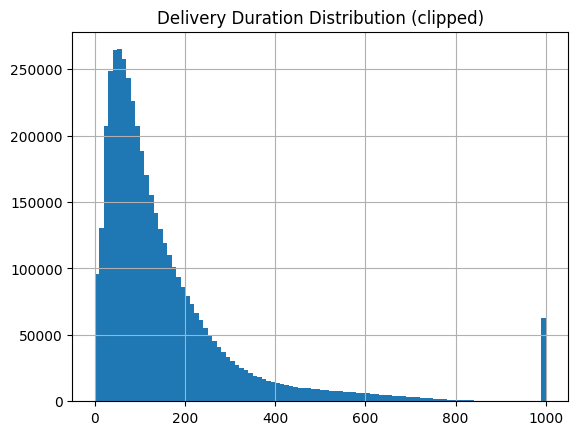

In [31]:
import matplotlib.pyplot as plt

df_fact_delivery["delivery_duration_minutes"].clip(0, 1000).hist(bins=100)
plt.title("Delivery Duration Distribution (clipped)")

In [32]:
df_fact_delivery["is_valid_for_bottleneck"] = (
    (df_fact_delivery["delivery_duration_minutes"] >= 0) &
    (df_fact_delivery["delivery_duration_minutes"] <= 1440)
)

/var/folders/w3/j17nd8hj0wbcrf5jvpndnw440000gn/T/ipykernel_15380/238336202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fact_delivery["is_valid_for_bottleneck"] = (


In [33]:
def duration_bucket(x):
    if x < 0:
        return "invalid"
    elif x <= 1440:
        return "standard_delivery"
    else:
        return "long_tail_delivery"

df_fact_delivery["delivery_duration_category"] = (
    df_fact_delivery["delivery_duration_minutes"]
    .apply(duration_bucket)
)

/var/folders/w3/j17nd8hj0wbcrf5jvpndnw440000gn/T/ipykernel_15380/3653487639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fact_delivery["delivery_duration_category"] = (


In [34]:
df_fact_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514661 entries, 0 to 4514660
Data columns (total 11 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   order_id                    int64         
 1   accept_time                 datetime64[ns]
 2   delivery_time               datetime64[ns]
 3   delivery_duration_minutes   Int64         
 4   city                        object        
 5   aoi_id                      int64         
 6   aoi_type                    int64         
 7   courier_id                  int64         
 8   ds                          int64         
 9   is_valid_for_bottleneck     boolean       
 10  delivery_duration_category  object        
dtypes: Int64(1), boolean(1), datetime64[ns](2), int64(5), object(2)
memory usage: 357.4+ MB


In [35]:
df_fact_delivery.describe()

,order_id,accept_time,delivery_time,delivery_duration_minutes,aoi_id,aoi_type,courier_id,ds
count,4.514661e+06,4514661,4514661,4514661.0,4.514661e+06,4.514661e+06,4.514661e+06,4.514661e+06
mean,2.257330e+06,2022-08-15 03:52:47.974298880,2022-08-15 06:58:37.517528576,185.82572,2.998049e+04,4.355784e+00,2.385268e+03,8.112479e+02
min,0.000000e+00,2022-05-01 06:11:00,2022-01-11 19:20:00,-421417.0,0.000000e+00,0.000000e+00,0.000000e+00,5.010000e+02
25%,1.128665e+06,2022-07-03 12:12:00,2022-07-03 15:09:00,56.0,1.487400e+04,1.000000e+00,1.206000e+03,7.030000e+02
50%,2.257330e+06,2022-08-20 07:33:00,2022-08-20 09:15:00,105.0,3.005500e+04,1.000000e+00,2.345000e+03,8.200000e+02
75%,3.385995e+06,2022-09-29 13:06:00,2022-09-29 15:47:00,193.0,4.446400e+04,8.000000e+00,3.588000e+03,9.290000e+02
max,4.514660e+06,2022-12-08 12:10:00,2022-12-31 21:03:00,166499.0,6.014900e+04,1.500000e+01,4.876000e+03,1.031000e+03
std,1.303271e+06,NaN,NaN,780.114327,1.729042e+04,5.527705e+00,1.390526e+03,1.653643e+02


In [38]:
df_fact_delivery.head()

,order_id,accept_time,delivery_time,delivery_duration_minutes,city,aoi_id,aoi_type,courier_id,ds,is_valid_for_bottleneck,delivery_duration_category
0,583722,2022-10-30 09:20:00,2022-10-30 10:30:00,70,Hangzhou,749,1,175,1030,True,standard_delivery
1,2819059,2022-10-31 09:47:00,2022-10-31 10:40:00,53,Hangzhou,749,1,175,1031,True,standard_delivery
2,2879432,2022-10-22 10:11:00,2022-10-22 15:03:00,292,Hangzhou,749,1,175,1022,True,standard_delivery
3,392295,2022-10-26 09:41:00,2022-10-26 10:30:00,49,Hangzhou,749,1,175,1026,True,standard_delivery
4,231864,2022-10-31 15:58:00,2022-10-31 16:41:00,43,Hangzhou,749,1,175,1031,True,standard_delivery


In [39]:
df_fact_delivery["city"].value_counts()

city
Hangzhou     1861600
Shanghai     1483864
Chongqing     931351
Yantai        206431
Jilin          31415
Name: count, dtype: int64